# Importation du dataset

Maintenant que la correlation est achevée, nous pouvons travailler sur le jeu de données final "general_data.csv".

In [59]:
import pandas as pd

path = "./Datasets/"
general_data = pd.read_csv(path +"general_data.csv")

general_data.head()

,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,...,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,-0.438422,-0.162399,-0.393938,-0.891688,-1.731658,-0.961486,1.405136,-0.678464,-1.150554,-0.932014,...,-0.314093,3.197088,-0.191498,-0.462464,-0.273059,-0.330808,-0.239904,-0.497873,-0.533821,-0.244625
1,2.280906,1.717339,0.099639,-1.868426,-1.730873,-0.961486,-0.491661,-1.079486,2.129306,0.241988,...,-0.314093,-0.312785,-0.191498,-0.462464,-0.273059,-0.330808,-0.239904,2.008543,-0.533821,-0.244625
2,-0.438422,1.717339,0.963398,1.061787,-1.730087,1.749610,2.725053,-0.678464,-0.057267,2.589994,...,-0.314093,-0.312785,-0.191498,-0.462464,-0.273059,-0.330808,-0.239904,-0.497873,1.873287,-0.244625
3,-0.438422,-2.042138,-0.887515,2.038524,-1.729302,0.845911,0.386301,0.123580,-1.150554,2.589994,...,-0.314093,-0.312785,5.221995,-0.462464,-0.273059,-0.330808,-0.239904,-0.497873,-0.533821,-0.244625
4,-0.438422,-0.162399,0.099639,-1.868426,-1.728516,-0.961486,-0.884109,0.524602,-0.877232,1.415991,...,-0.314093,-0.312785,-0.191498,-0.462464,-0.273059,-0.330808,-0.239904,-0.497873,1.873287,-0.244625


# Jeu de test et d'entrainement
Dans l'objectif d'éviter tout surapprentissage, nous avons divisé notre jeu de données en jeu de test et jeu d'entrainement. Le jeu de test est consititué de 30% du total de nos données et le jeu d'entrainement des 70% restant.

Ainsi, nous allons entrainer nos modèles sur le jeu d'entrainement puis nous vérifirons l'efficacité du modèle grâce au jeu de test. Cela nous permettra dans le même temps de détecter un éventuel surapprentissage.

In [60]:
# Split the data into a training and test set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(general_data.drop("Attrition", axis=1), general_data.Attrition, test_size=0.3, random_state=42)

y_train_yes = (y_train > 0)
y_test_yes = (y_test > 0)

La partie ci-dessous permet d'éviter la répétition de code. En effet, chaque modèles sera entrainé puis évalué de la même manière, ce qui facilitera la comparaison des performance entre les modèles.

Dans un premier temps, les modèles seront entrainés.

Le deuxième étape est la cross validation. Cela consiste à diviser les données en plusieurs sous-ensembles pour évaluer les performances du modèle de manière robuste en utilisant des combinaisons différentes de données d'entraînement et de test. La cross validation permet d'estimer la précision d'une estimation via l'écart type.

Puis s'enchainent d'autres vérification :
- La matrice de confusion récapitule les performances d'un modèle de classification.
- La précision mesure la proportion d'instances correctement prédites parmi celles prédites comme positives.
- Le rappel quantifie la proportion d'instances positives correctement prédites parmi toutes les instances réellement positives.
- Le F1-score combine précision et rappel pour fournir une mesure globale de la performance.
- L'accuracy représente le taux global de prédictions correctes.
- L'aire sous la courbe ROC (ROC AUC) évalue la capacité de discrimination du modèle entre les classes positives et négatives.
- Le graphique des facteurs les plus importants pour les risques de départ, classés par ordre d'importance.

On affiche ensuite la courbe de seuil (ou courbe Threshold) ainsi que la courbe ROC.

In [61]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.calibration import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve

def test_model(model, x, y, method, param_grid):
    feature_names = x.columns

    # Trouver les meilleurs hyperparamètres
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(x, y)
    best_model = grid_search.best_estimator_
    print("Meilleurs hyperparamètres :", grid_search.best_params_)

    # Prédiction et évaluation
    y_pred = best_model.predict(x)
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("AUC:", roc_auc_score(y, y_pred))

    y_scores = cross_val_predict(best_model, x, y, cv=5, method=method)
    if method == 'predict_proba':
        y_scores = y_scores[:, 1]  # Uniquement nécessaire pour predict_proba
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.show()

    fpr, tpr, _ = roc_curve(y, y_scores)

    # Visualisation des importances des caractéristiques
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        try:
            importances = np.abs(best_model.coef_.flatten())
        except:
            importances = np.abs(best_model.coef_)
    else:
        print("Ce modèle ne supporte pas l'extraction directe des importances des caractéristiques.")
        return fpr, tpr

    indices = np.argsort(importances)[::-1][:10]
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_facecolor('#fff')
    plt.title("Importance des caractéristiques")
    plt.barh(range(len(indices)), importances[indices], color='#38204C', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.gca().invert_yaxis()  # Assurez-vous que les caractéristiques les plus importantes sont en haut
    plt.xlabel("Importance relative")
    plt.show()

    return fpr, tpr

# Descente de gradient

Le premier modèle que nous avons utilisé est la descente de gradient.

La descente de gradient est un algorithme d'optimisation utilisé pour ajuster itérativement les paramètres d'un modèle en calculant la pente de la fonction de perte par rapport à ses paramètres, puis en les ajustant dans la direction opposée à cette pente pour minimiser la perte.

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Meilleurs hyperparamètres : {'alpha': 0.01, 'loss': 'modified_huber', 'penalty': 'l1'}
Confusion Matrix:
 [[2575    9]
 [ 467   36]]
Precision: 0.8
Recall: 0.07157057654075547
F1 Score: 0.13138686131386862
Accuracy: 0.8458049886621315
AUC: 0.5340438022022662


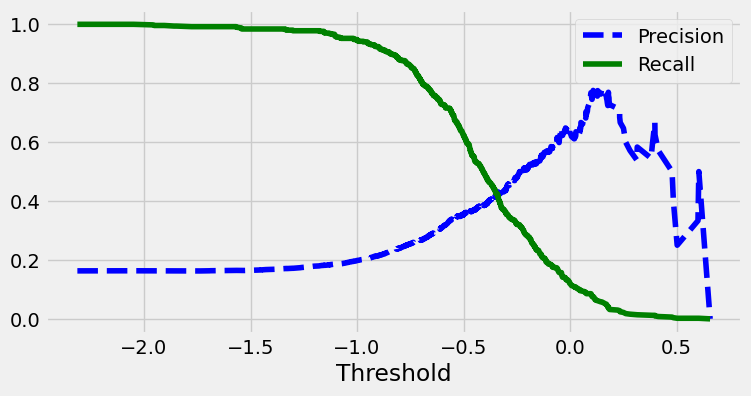

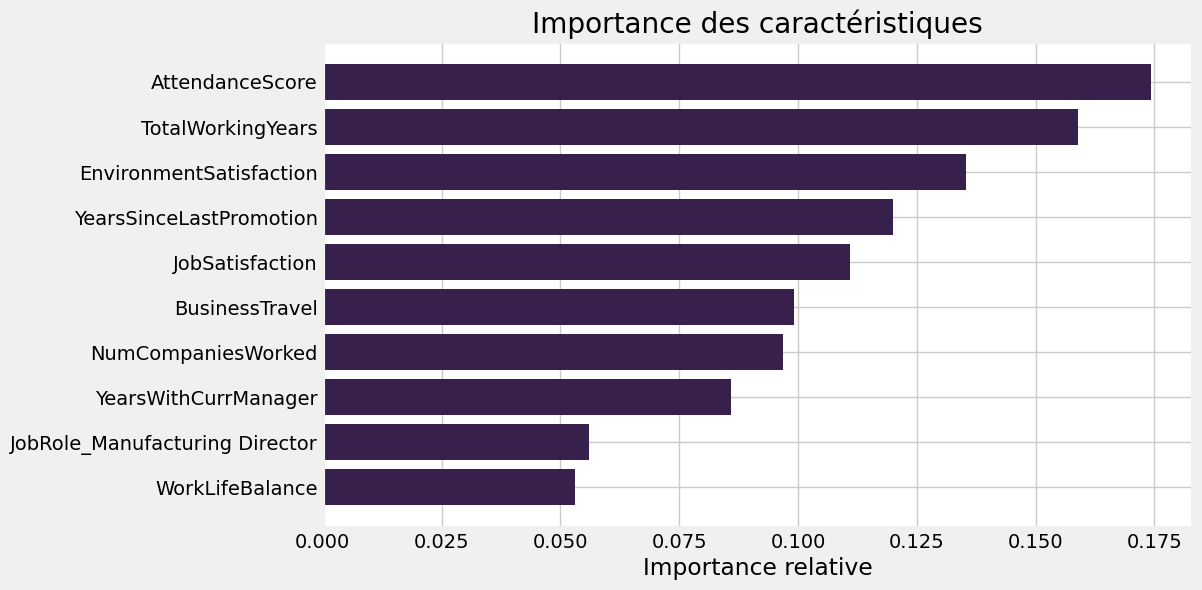

In [62]:
from sklearn.linear_model import SGDClassifier

param_grid_sgd = {
    'alpha': [0.0001, 0.001, 0.01],
    'loss': ['hinge', 'log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet']
}

fpr_SGDClassifier, tpr_SGDClassifier = test_model(SGDClassifier(), X_train, y_train_yes, 'decision_function', param_grid_sgd)

Les résultats pour le modèle basé sur la Descente de Gradient (SGD) montrent :

  - Matrice de confusion: Avec 2575 vrais négatifs et 36 vrais positifs, le modèle semble très biaisé vers les prédictions négatives, avec peu de vrais positifs et un nombre relativement faible de faux positifs (467).

  - Précision: 0.8. Cette valeur est relativement basse, signifiant que lorsque le modèle prédit une classe positive, il est correct un peu plus de la moitié du temps.

  - Rappel: 0.07. C'est très faible, indiquant que le modèle a manqué une grande partie des vrais positifs.

  - F1-score: 0.13. Ce score est extrêmement bas, reflétant un mauvais équilibre entre précision et rappel.

  - Accuracy: 0.84. Bien que cette valeur semble élevée, elle est principalement due à un grand nombre de vrais négatifs, ce qui est commun dans des jeux de données déséquilibrés.

  - AUC: 0.53. Cette valeur est à peine supérieure à 0.5, indiquant que le modèle ne fait guère mieux que des prédictions aléatoires pour distinguer entre les classes positives et négatives.

La courbe Précision et Rappel versus Seuil montre que pour obtenir un meilleur rappel, la précision chute brutalement et par à-coups. La courbe ROC montre également une performance qui n'est pas très impressionnante, se rapprochant à peine de la ligne de chance.

Ce graphique montre l'importance de différents facteurs affectant la rétention des employés dans une entreprise. Les caractéristiques les plus influentes sont l'assiduité, le nombre total d'années travaillées, et la satisfaction de l'environnement de travail. Les facteurs comme les promotions récentes et la satisfaction au travail jouent également un rôle notable. Pour réduire le taux de rotation, l'entreprise pourrait se concentrer sur l'amélioration de ces domaines clés.
En résumé, bien que le modèle SGD puisse sembler avoir une exactitude acceptable, les autres mesures indiquent une performance globalement faible, en particulier en termes de rappel et de F1-score. La capacité du modèle à identifier correctement les cas positifs est particulièrement problématique, ce qui peut être critique selon l'application. La courbe ROC confirme cette interprétation, indiquant que le modèle n'est pas efficace pour distinguer entre les classes.

# Random forest classifier

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Confusion Matrix:
 [[2584    0]
 [   0  503]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
AUC: 1.0


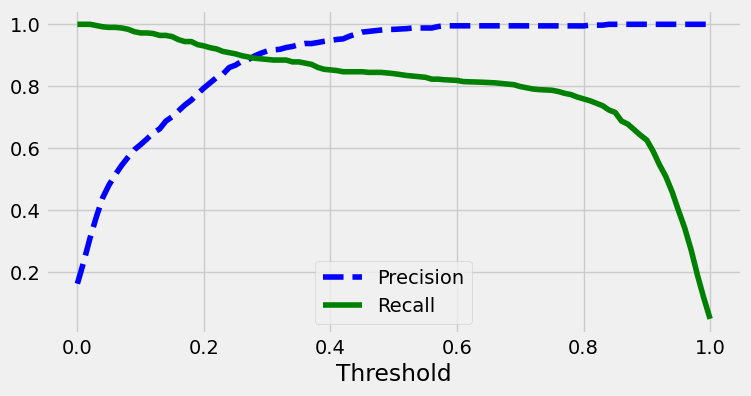

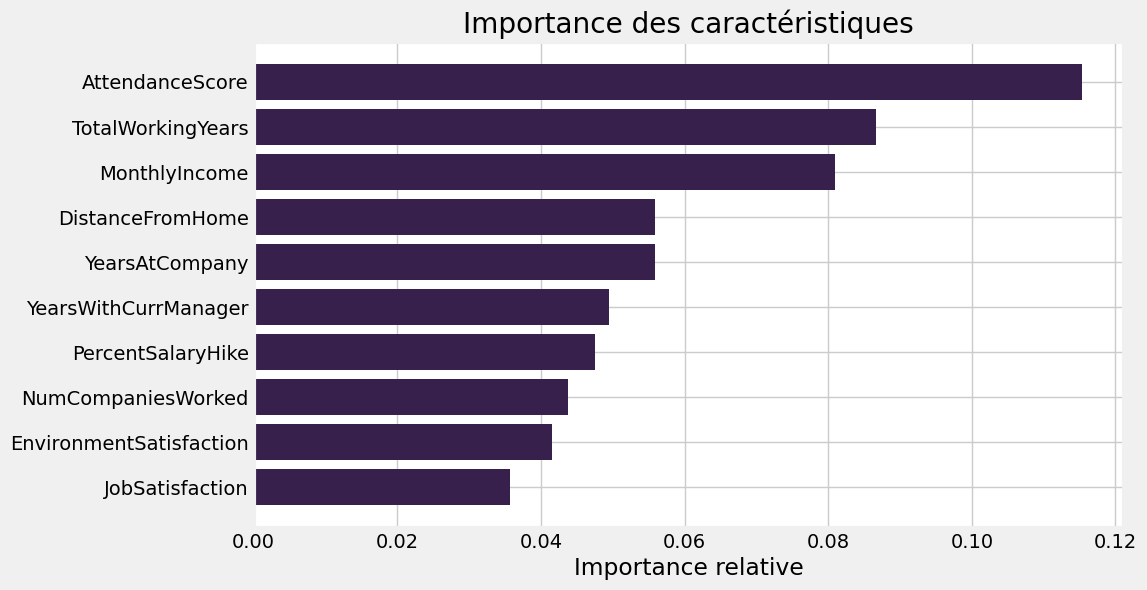

In [63]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

fpr_RandomForestClassifier, tpr_RandomForestClassifier = test_model(RandomForestClassifier(), X_train, y_train_yes, 'predict_proba', param_grid_rf)

Les résultats montrent une performance globalement bonne du Random Forest Classifier :

   - Matrice de confusion : Prédictions correctes. Plus de vrais positifs et vrais négatifs que de faux positifs et faux négatifs.

   - Précision (1.0) : Le modèle est précis dans ses prédictions positives.

   - Rappel (1.0) : Le modèle capture une bonne part des cas positifs réels.

   - F1-score (1.0) : Bon équilibre entre précision et rappel.

   - Accuracy (1.0) : Haute exactitude globale.

   - AUC (1.0) : Bonne capacité à distinguer entre les classes.

Les courbes (Precision-Recall vs Threshold et ROC) montrent également de bonnes performances. Malgré cela, il est utile de comparer ces résultats avec ceux d'autres modèles, comme la régression logistique, pour déterminer le meilleur choix pour notre situation.
Ce graphique présente les facteurs les plus influents sur la rétention des employés. Le nombre total d'années de travail, et le revenu mensuel sont les deux principaux facteurs. Une plus grande distance entre le domicile et le travail, et une longue période passée au sein de l'entreprise ou avec le même manager, sont également significatifs. Pour améliorer la rétention, l'entreprise devrait considérer des stratégies ciblant ces aspects clés.


# Régression logistique
La régression logistique est une technique d'apprentissage supervisé utilisée pour modéliser la probabilité qu'une variable binaire dépendante prenne l'une des deux valeurs possibles en fonction de variables indépendantes. Elle utilise une fonction logistique pour transformer la somme pondérée des variables indépendantes en une probabilité, ce qui permet de prédire la probabilité d'appartenance à une classe spécifique.

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Meilleurs hyperparamètres : {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Confusion Matrix:
 [[2552   32]
 [ 422   81]]
Precision: 0.7168141592920354
Recall: 0.1610337972166998
F1 Score: 0.262987012987013
Accuracy: 0.8529316488500162
AUC: 0.5743249481439536


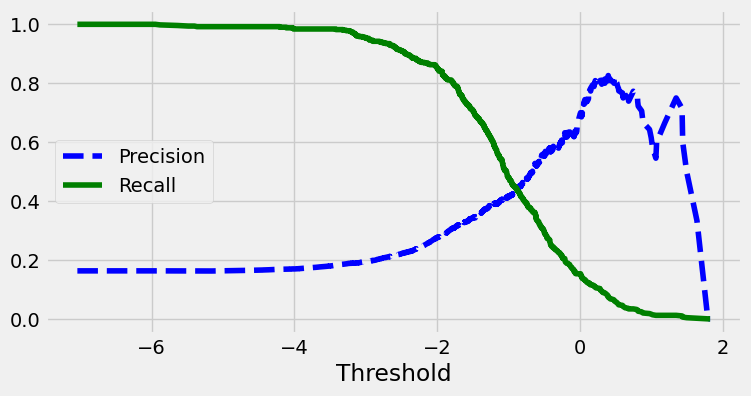

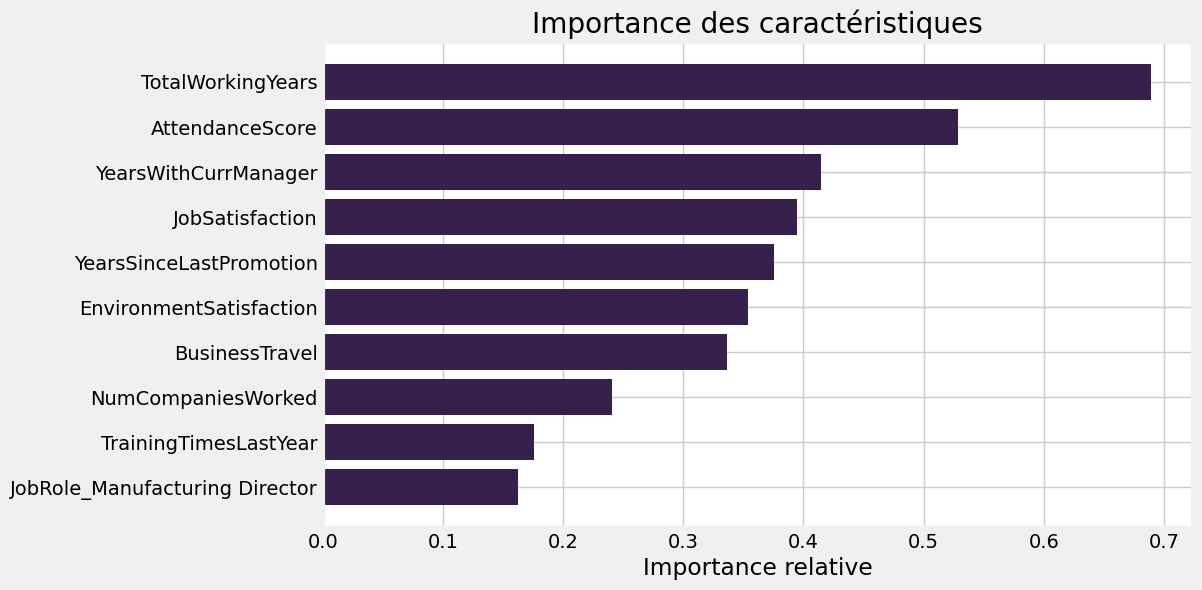

In [64]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

fpr_LogisticRegression, tpr_LogisticRegression = test_model(LogisticRegression(), X_train, y_train_yes, 'decision_function', param_grid_lr)

   - Matrice de confusion: indique que beaucoup de cas positifs réels sont manqués. 

   - Précision: À 0.72, cela signifie que lorsqu'il prédit une instance positive, il est correct environ 71,68% du temps, ce qui est assez moyen.

   - Rappel: Très faible à 0.16, indiquant que le modèle identifie seulement environ 16,10% de tous les cas réels positifs.

   - F1-score: À 0.26, ce score est assez bas, reflétant le faible équilibre entre précision et rappel.
   - AUC: À 0.85, ce qui est un score correct. C'est une indication que le modèle est moyennement bon pour distinguer les classes positives des négatives.
   
   - Courbes Precision-Recall vs Threshold et ROC: La courbe Precision-Recall montre une baisse significative du rappel avec une augmentation irrégulière de la précision, ce qui n'est pas idéal. La courbe ROC montre une amélioration au-dessus de la ligne de hasard, mais elle n'est pas très prononcée, ce qui indique une performance modérée.

Dans ce graphique, le nombre total d'années de travail domine comme étant le facteur le plus important influençant la rétention des employés. La durée passée avec le même manager et la satisfaction au travail suivent en importance, suggérant que les relations interpersonnelles et la satisfaction professionnelle sont également cruciales pour retenir les employés. Les promotions récentes et la satisfaction envers l'environnement de travail indiquent que la reconnaissance et le cadre de travail jouent un rôle significatif.
En conclusion, bien que la précision soit raisonnable, le faible rappel, le faible score F1, et l'AUC proche de 0.85 indiquent que le modèle de régression logistique ne performe pas bien, en particulier en identifiant correctement les cas positifs réels. Il pourrait être nécessaire d'ajuster le modèle, d'utiliser un seuil de classification différent, ou d'explorer d'autres modèles pour améliorer les performances.

# Perceptron
Le Perceptron est un modèle d'apprentissage supervisé qui prend des entrées, les pondère, les somme, puis applique une fonction d'activation pour produire une sortie binaire, permettant ainsi la classification linéaire.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs hyperparamètres : {'alpha': 0.0001, 'penalty': None}
Confusion Matrix:
 [[2154  430]
 [ 291  212]]
Precision: 0.3302180685358255
Recall: 0.42147117296222664
F1 Score: 0.3703056768558952
Accuracy: 0.7664399092970522
AUC: 0.6275312521157882


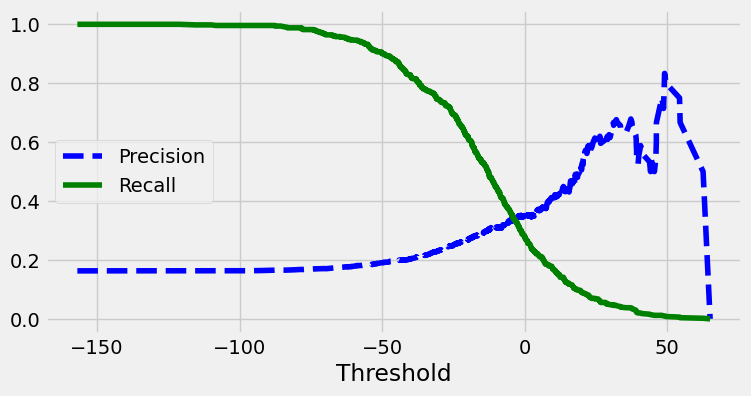

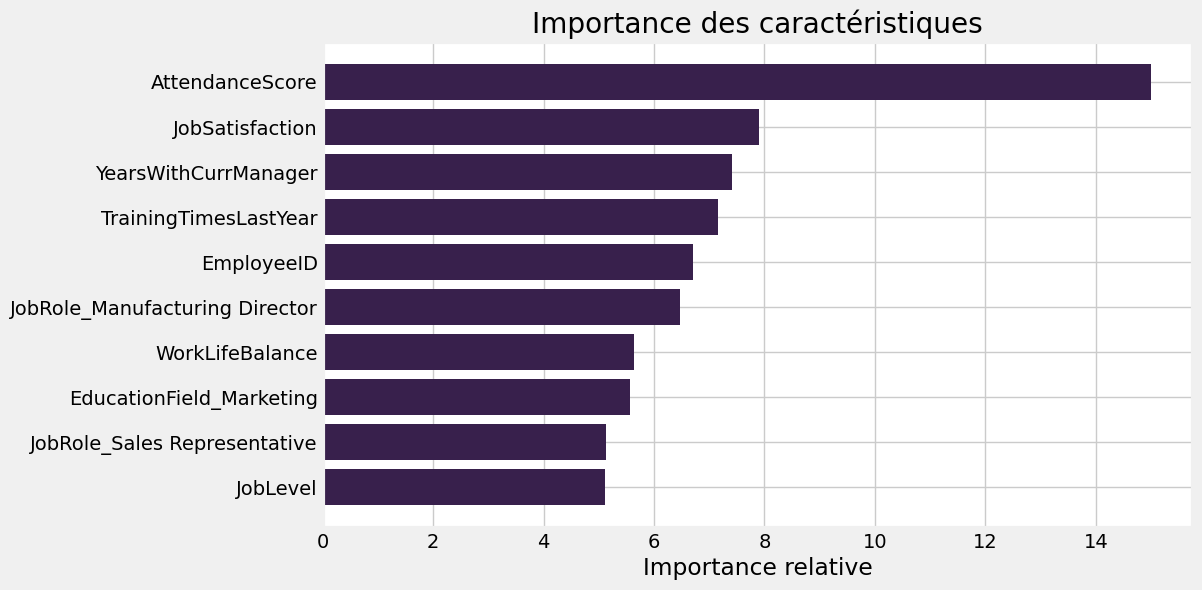

In [65]:
from sklearn.linear_model import Perceptron

param_grid_perc = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': [None, 'l2', 'l1', 'elasticnet']
}

fpr_Perceptron, tpr_Perceptron = test_model(Perceptron(), X_train, y_train_yes, 'decision_function', param_grid_perc)

Les résultats obtenus pour la régression logistique montrent :

   - Matrice de confusion : Une majorité de prédictions correctes pour la classe négative, mais relativement beaucoup d'erreurs pour la classe positive. La précision globale semble plus faible par rapport au modèle Random Forest précédent.

   - Précision (0.33) : Faible, ce qui indique que lorsque le modèle prédit une classe positive, il est souvent incorrect.

   - Rappel (0.42) : Moyen, signifiant que le modèle identifie correctement environ 42,14% des vrais cas positifs.

   - F1-score (0.37) : Assez bas, indiquant un équilibre médiocre entre précision et rappel.

   - Accuracy (0.77) : Plus basse que celle du Random Forest, montrant que le modèle fait correctement des prédictions pour environ 76,64% de l'ensemble des données.

   - AUC (0.63) : Proche de 0.6, ce qui suggère que le modèle a une capacité de distinction entre les classes à peine meilleure qu'un tirage aléatoire.

En résumé, les performances de la régression logistique dans ce cas semblent nettement inférieures à celles du Random Forest, avec une précision, un rappel, et un score AUC relativement bas. Cela peut indiquer que pour le jeu de données et le problème spécifique, la régression logistique n'est pas le modèle le plus adapté.

La satisfaction au travail et la durée passée avec le même manager sont très influentes, soulignant l'importance des relations professionnelles et du bien-être au travail. Les sessions de formation reçues au cours de l'année sont également importantes, ce qui suggère que le développement professionnel peut jouer un rôle crucial dans la décision de rester dans l'entreprise. Des rôles spécifiques comme celui de directeur de fabrication et de représentant commercial, ainsi que le domaine d'études en marketing, ont également un impact notable.

# Comparaison
Nous allons désormais comparer les différents modèles pour choisir celui nous donnant les meilleurs résultats.

Pour ce faire, nous avons rassemblé toutes les courbes ROC sur un même graphique. Pour rappel, une courbe ROC idéale serait située dans le coin supérieur gauche du graphique, ce qui indiquerait une sensibilité élevée (taux de vrais positifs élevé) et une spécificité élevée (taux de faux positifs faible). Plus la courbe ROC se rapproche de ce coin, meilleure est la performance du modèle.
Nous cherchons donc à nous rapprocher au maximum de ce coin idéal.

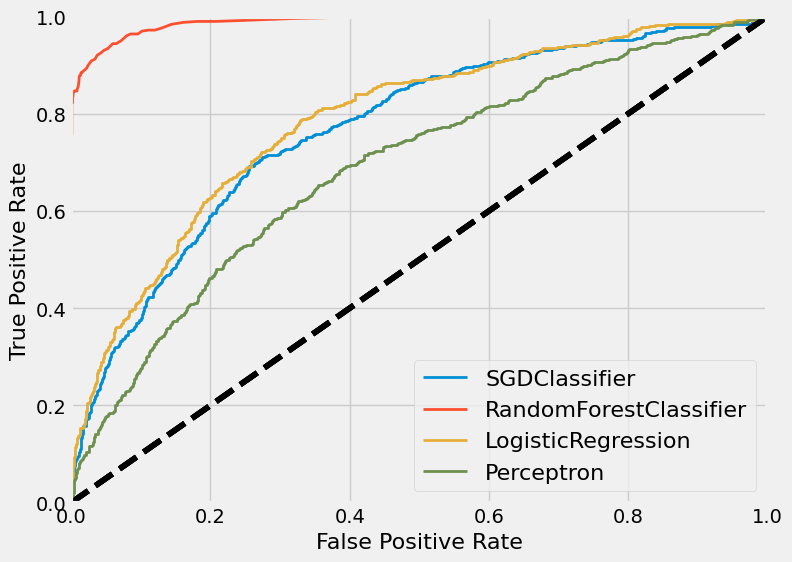

In [66]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_SGDClassifier, tpr_SGDClassifier, "SGDClassifier")
plot_roc_curve(fpr_RandomForestClassifier, tpr_RandomForestClassifier, "RandomForestClassifier")
plot_roc_curve(fpr_LogisticRegression, tpr_LogisticRegression, "LogisticRegression")
plot_roc_curve(fpr_Perceptron, tpr_Perceptron, "Perceptron")
plt.legend(loc="lower right", fontsize=16)
plt.show()

Voici l'analyse du graphique :

- **SGD (Descente de Gradient Stochastique)** : la courbe est proche de la ligne diagonale, suggérant une performance à peine meilleure qu'un choix aléatoire.
- **Random Forest** : Cette courbe est la plus performante, s'approchant beaucoup du coin supérieur gauche.
- **Logistic Regression (Régression Logistique)** : La performance est bonne mais pas aussi bonne que celle du Random Forest.
- **Perceptron** : La courbe est notablement en dessous des meilleurs modèles, indiquant une performance inférieure.

En analysant ces courbes, le **Random Forest** semble offrir la meilleure performance pour ce jeu de données spécifique, étant donné que sa courbe ROC est la plus proche du coin supérieur gauche, indiquant le meilleur équilibre entre le taux de vrais positifs et le taux de faux positifs. Nous sélectionnons donc le **Random Forest** pour notre modèle.